# Toy Model reproducing the U-Shape relationship between synthetic data ratio and entropy

## Model 1: With Accumulation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = 0.1

N = 500

T = 20

freq = 100

temp = 0.00000001

range_N = 1000

bias_idx = 2

pooled = True


n_rep = 50

# Intial sample

def softmax_1d(x, tau, shift=True):
    """
    Shifting prevents overflow
    """
    if shift:
        x = x - np.max(x)
    e_x = np.exp(x / tau)
    return e_x / np.sum(e_x)

def bias(value, biased = True):
    # if value % 50 == 0:
    #     return 5
    # elif value % 25 == 0:
    #     return 4
    if value % bias_idx == 0:
        return 1
    else:
        if biased:
            return 0.0001
            # return 0.0075
        return 1

def run(x, N, T, freq=None, biased = True, aligned = False):

    # initial_bias = [1.01 if i % 10 == 0 else 1 if i % 5 == 0 else 1 for i in range(100)]

    # initial_bias = [100 if i % 10 == 0 else 90 if i % 5 == 0 else 0 for i in range(100)]
    initial_bias = [bias(i, biased) for i in range(range_N)]
    # from IPython import embed; embed()

    ia_share = int(x * N)
    human_share = N - ia_share

    # convert histogram to a probability distribution using temperature

    # ia_proba = np.array(initial_bias) / sum(initial_bias)
    # # ia_proba = np.exp(ia_proba / temp)
    # # ia_proba = ia_proba / sum(ia_proba)
    # #sample from ia_proba
    # ia_sample = np.random.choice(np.arange(0, 100), size=ia_share, p=ia_proba)
    # #sample from uniform distribution
    # human_sample = np.random.uniform(0, 100, size=human_share)
    # #combine the two samples
    # combined_sample = np.concatenate((ia_sample, human_sample))

    # Alternatively, the first sample is only human:
    human_sample = np.random.uniform(0, range_N, size=N)  # todo: also make overlap with ai data small
    combined_sample = human_sample

    histos = []

    pool = combined_sample.copy()
    

    for t in range(T):

        ia_share = int(x * N)
        human_share = N - ia_share
        print("Human share:", human_share)

        # if x == 0.25:
        #     from IPython import embed; embed()

        # convert combined sample to a histogram
        if pooled: 
                hist, _ = np.histogram(pool, bins=range_N, range=(0, range_N))
        else:
            hist, _ = np.histogram(combined_sample, bins=range_N, range=(0, range_N))

        # maginify values that are aligned with initial bias
        # if x == 0.25 and t == 1 :
        #     from IPython import embed; embed()

        proba = (hist * initial_bias) / sum(hist * initial_bias)
        # proba = (hist + initial_bias) / sum(hist + initial_bias)
        # convert histogram to a probability distribution using temperature
        # proba = softmax_1d(hist, temp)

        if freq and t % freq == 0:
            print(f"Time step {t}")
            print(f"histogram: {hist}")
            # plot the histogram
            plt.figure(figsize=(10, 6))
            plt.bar(np.arange(0, range_N), hist, width=1)
            # add kde plots for proba1 and proba2
            plt.plot(np.arange(0, range_N), proba * N, label="Proba1")
            plt.legend()

            plt.xlim(0, range_N)
            plt.xlabel("Value")
            plt.ylabel("Frequency")
            plt.title(f"Histogram at time step {t}")
            plt.show()

        # sample from proba
        ia_sample = np.random.choice(np.arange(0, range_N), size=ia_share, p=proba)


        # Sample to analyze
        ia_sample_analysis = np.random.choice(np.arange(0, range_N), size=N, p=proba)
        # convert to hist
        hist_ia, _ = np.histogram(ia_sample_analysis, bins=range_N, range=(0, range_N))
        histos.append(hist_ia)
        # sample from uniform distribution
        if aligned:
            human_sample = np.random.uniform(0, range_N, size=human_share)
        else:
            # human_sample = (np.random.uniform(0, range_N, size=human_share) // 5) * 5 + 1
            human_sample = (np.random.uniform(0, range_N, size=human_share) // bias_idx) * bias_idx + np.random.uniform(1, bias_idx, size=human_share)//1
        # combine the two samples
        combined_sample = np.concatenate((ia_sample, human_sample))
        # combined_sample = np.concatenate((ia_sample, human_sample, combined_sample)) # accumulation (todo; skip first time))
        #add to pool
        pool = np.concatenate((pool, combined_sample))
    return histos


def get_histo_variance(hist):
    # convert histogram to a probability distribution
    proba = hist / sum(hist)
    # calculate the mean
    mean = np.sum(np.arange(0, range_N) * proba)
    # calculate the variance
    variance = np.sum((np.arange(0, range_N) - mean) ** 2 * proba)
    return variance


def get_similarity(histos):
    # distance between first and last histogram
    dist = np.abs(histos[0] - histos[-1])

    # max theoretical distance
    max_dist = 2 * np.sum(histos[0])
    # calculate the loss
    loss = np.sum(dist) / max_dist
    return 1 - loss

from scipy.stats import entropy
def get_similarity_with_uniform(histos):

    # distance between last histo and uniform distribution
    last_histo = histos[-1]
    # convert histogram to a probability distribution
    proba = last_histo / sum(last_histo)
    return entropy(proba)

    # uniform distribution
    uniform = np.ones(range_N) / range_N
    # calculate the distance
    dist = np.abs(proba - uniform)
    # max theoretical distance
    max_dist = 2 * np.sum(proba)
    loss = np.sum(dist) / max_dist
    return 1 - loss


def run_and_plot(title = None, biased = True, aligned = False):
    import matplotlib.pyplot as plt
    import numpy as np
    sim_means = []
    sim_stds = []

    variance_means = []
    variance_stds = []


    x_values = np.arange(0.0, 1.05, 0.05)

    all_histos = {}
    for x in np.arange(0.0, 1.05, 0.05):
        print(f"Running {n_rep} simulations with x = {x}")
        rep_histos = []
        rep_sim = []
        rep_var = []

        for i in range(n_rep):
            # run the simulation
            if x == 0 and i == 0:
                freq = None
            else:
                freq = None
            histos = run(x, N, T, freq, biased=biased, aligned=aligned)
            loss = get_similarity_with_uniform(histos)
            rep_sim.append(loss)
            rep_histos.append(histos)
            # calculate the variance of the histograms
            variance = get_histo_variance(histos[-1])
            rep_var.append(variance)

        sim_means.append(np.mean(rep_sim))
        sim_stds.append(np.std(rep_sim))
        variance_means.append(np.mean(rep_var))
        variance_stds.append(np.std(rep_var))
        all_histos[x] = rep_histos.copy()

    import matplotlib.pyplot as plt
    import numpy as np

    # Create a single figure with 4 subplots
    fig, axes = plt.subplots(4, 1, figsize=(12, 20), sharex=False)

    # --- Plot 1: Similarity Curve ---
    axes[0].plot(x_values, sim_means, label="Mean Entropy")
    axes[0].fill_between(x_values, np.array(sim_means) - np.array(sim_stds),
                        np.array(sim_means) + np.array(sim_stds), alpha=0.2, label="Standard Deviation")
    axes[0].set_xlabel("x")
    axes[0].set_ylabel("Entropy")
    axes[0].set_title(title)
    axes[0].legend()

    # --- Plot 4: First histogram (x = 0.0) ---
    hist = all_histos[x_values[0]][0][T-1]
    # hist = all_histos[1.0][0][T-1]
    axes[1].bar(np.arange(0, range_N), hist, width=1)
    axes[1].set_xlim(0, range_N)
    axes[1].set_yscale("log")   
    axes[1].set_ylabel("Frequency")
    axes[1].set_title(f"Final Histogram at time step {T} with x = {x_values[0]:.2f}, Entropy = {get_similarity_with_uniform([hist]):.4f}")
    print(f"Final histogram: {hist}")
    print(f"Variance: {get_histo_variance(hist)}")

    # --- Plot 3: Middle histogram (x = 0.5) ---
    midlle = len(x_values) // 2
    hist = all_histos[x_values[midlle]][0][T-1]
    axes[2].bar(np.arange(0, range_N), hist, width=1)
    axes[2].set_xlim(0, range_N)
    axes[2].set_yscale("log")   

    axes[2].set_ylabel("Frequency")
    axes[2].set_title(f"Histogram at time step {T} with x = {x_values[midlle]:.2f}, Entropy = {get_similarity_with_uniform([hist]):.4f}")
    print(f"Middle histogram: {hist}")
    print(f"Variance: {get_histo_variance(hist)}")


    # --- Plot 2: Final histogram (x = 1.0) ---
    hist = all_histos[1.0][0][T-1]
    axes[3].bar(np.arange(0, range_N), hist, width=1)
    axes[3].set_xlim(0, range_N)
    axes[3].set_yscale("log")   
    axes[3].set_xlabel("Value")
    axes[3].set_ylabel("Frequency")
    axes[3].set_title(f"First Histogram at time step {T} with x = {x_values[-1]:.2f}, Entropy = {get_similarity_with_uniform([hist]):.4f}")
    print(f"First histogram: {hist}")
    print(f"Variance: {get_histo_variance(hist)}")


    #Increase the size of all text
    for ax in axes:
        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(14)
        ax.title.set_fontsize(16)
        ax.xaxis.label.set_size(16)
        ax.yaxis.label.set_size(16)


    # Final layout adjustments
    plt.tight_layout()
    plt.show()



Running 50 simulations with x = 0.0
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share:

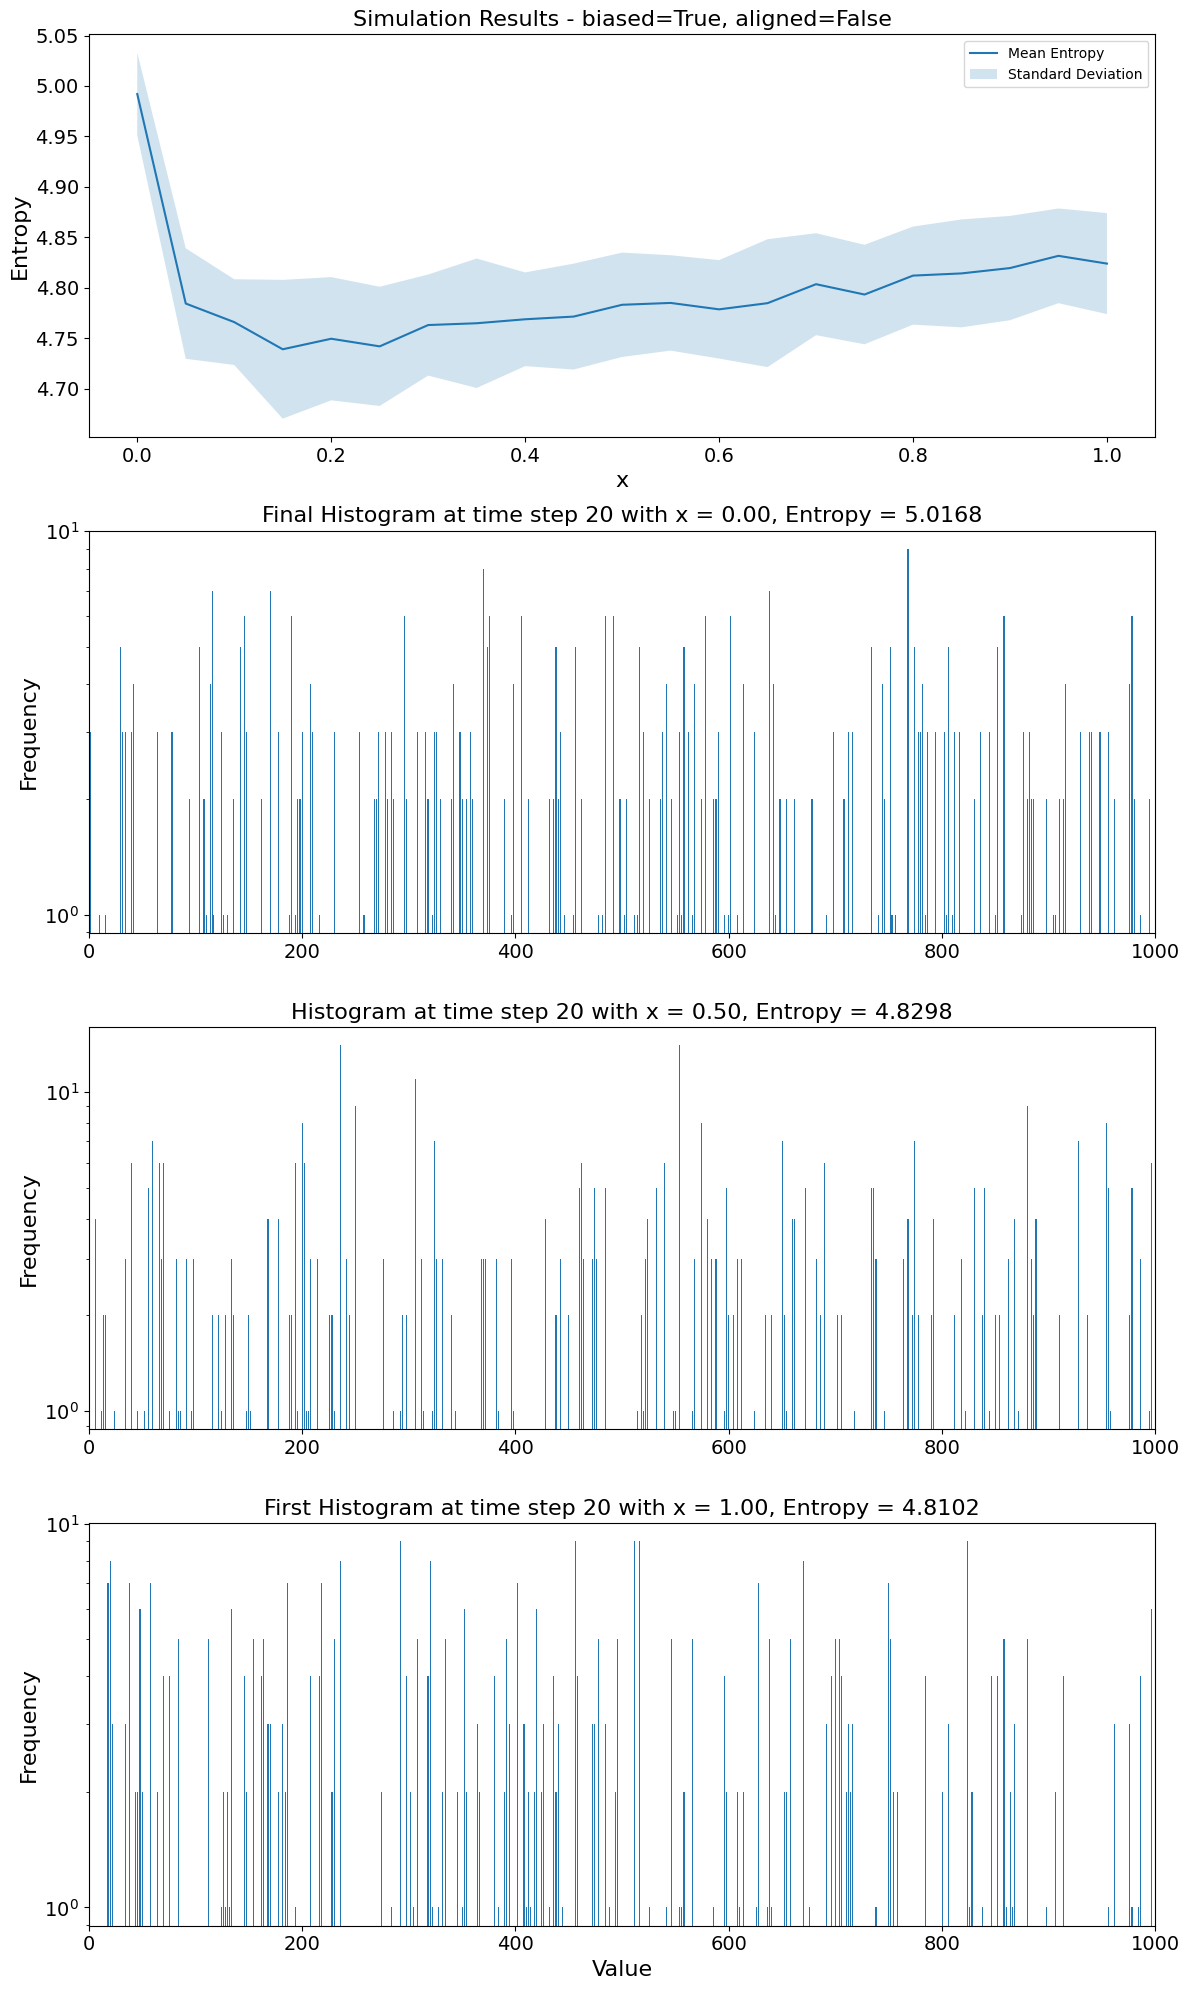

Running 50 simulations with x = 0.0
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share:

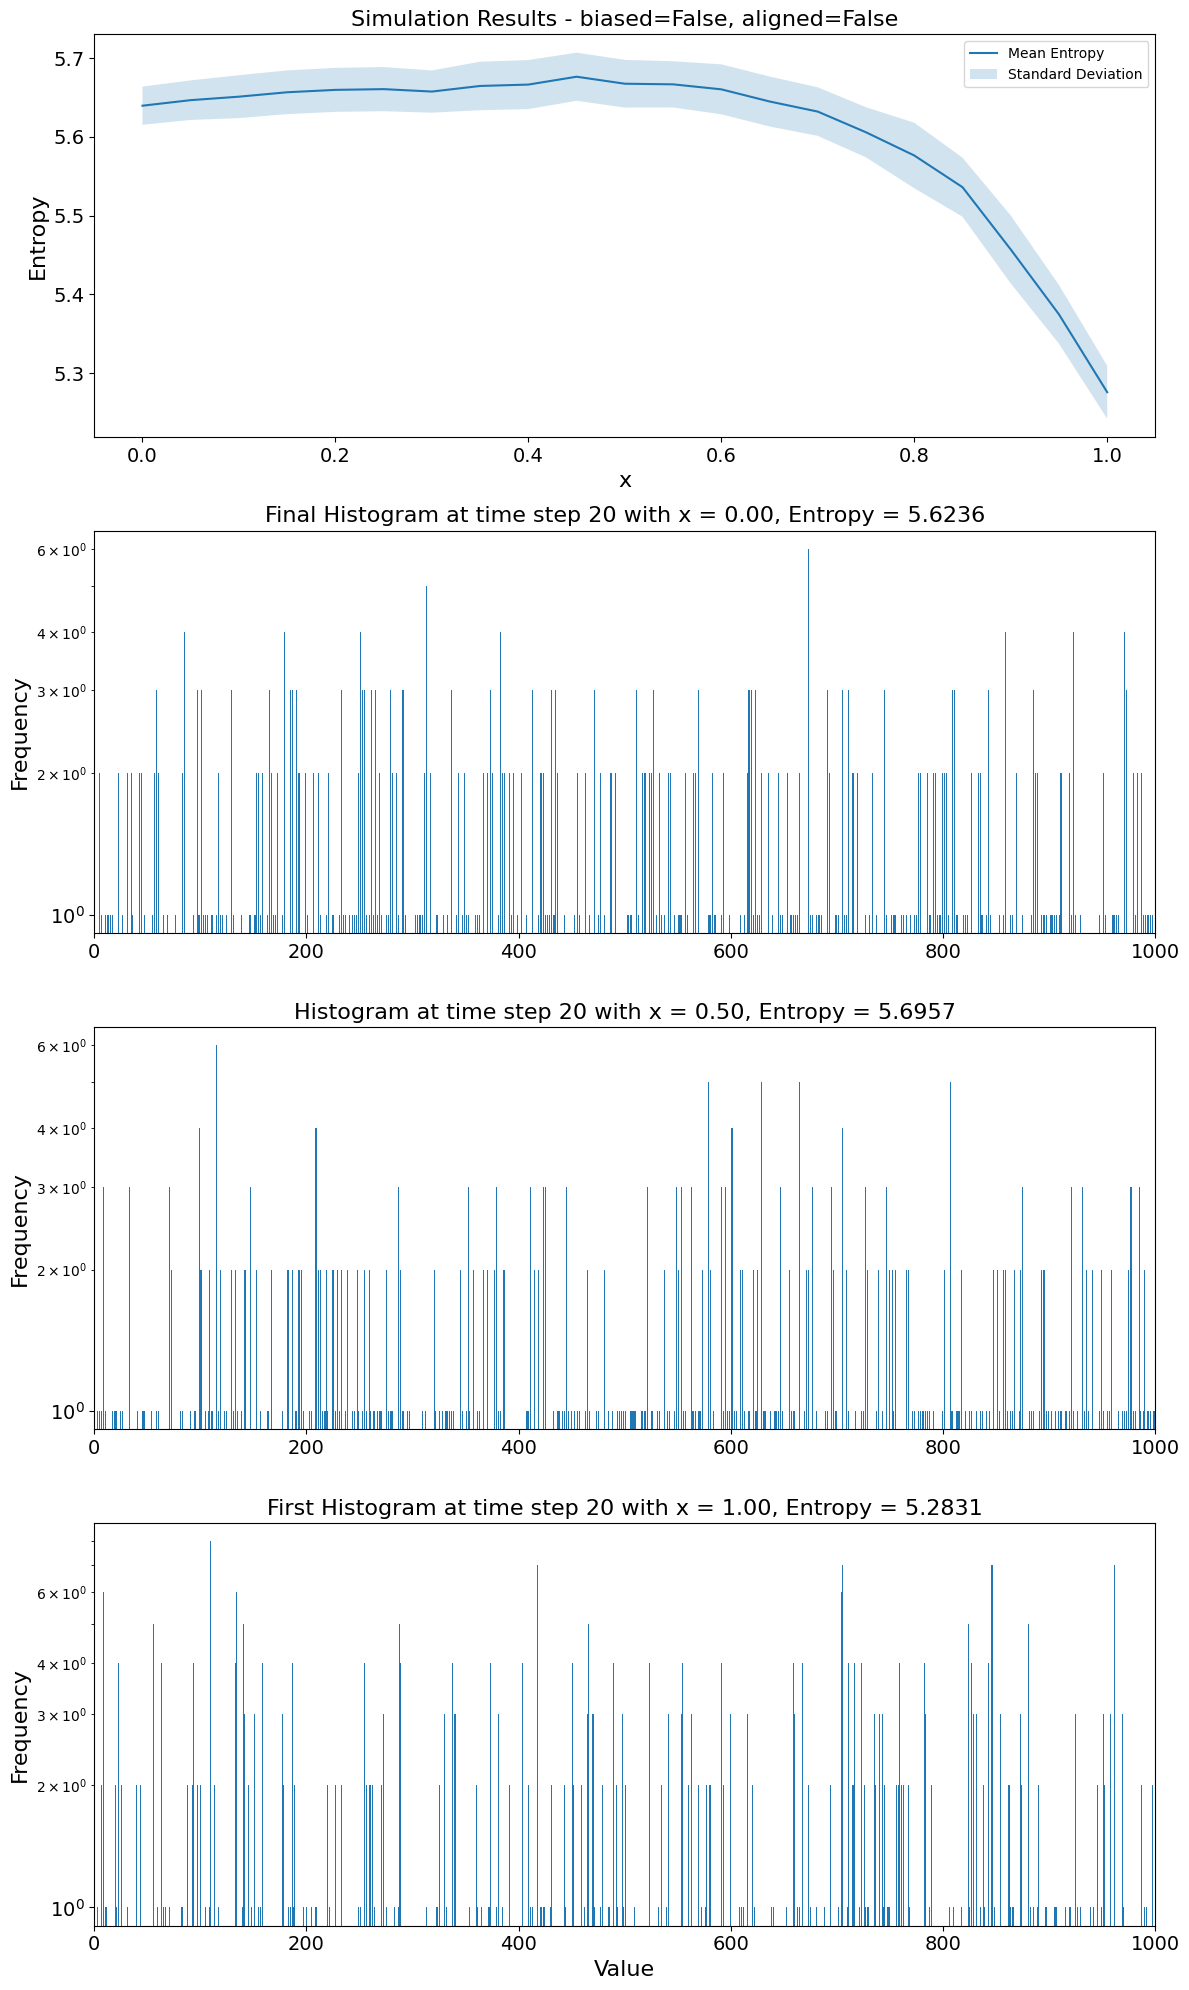

Running 50 simulations with x = 0.0
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share:

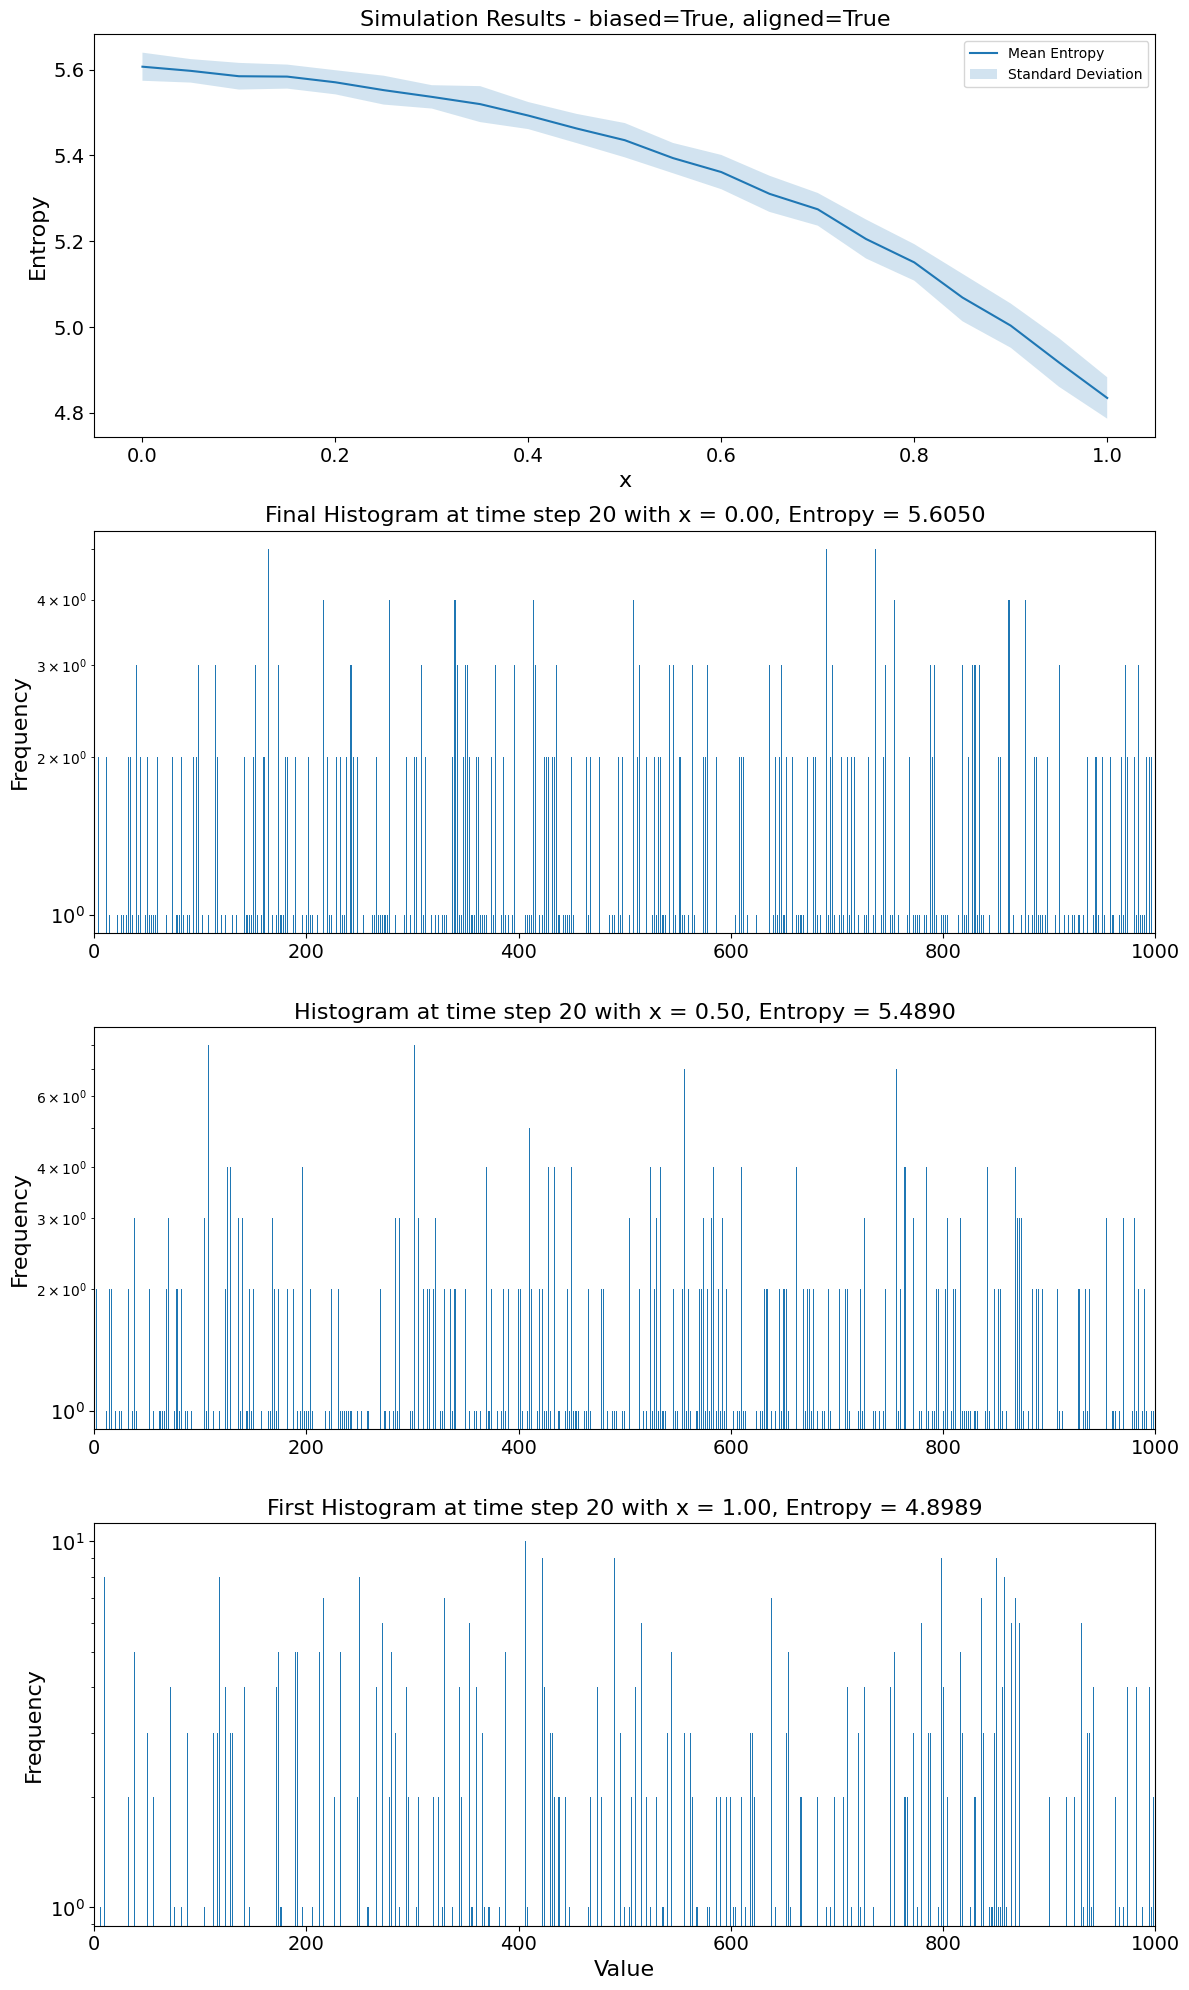

In [ ]:
run_and_plot(title="Simulation Results - biased=True, aligned=False", biased=True, aligned=False)
run_and_plot(title="Simulation Results - biased=False, aligned=False", biased=False, aligned=False)
run_and_plot(title="Simulation Results - biased=True, aligned=True", biased=True, aligned=True)


## Model 2: Without Accumulation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = 0.1

N = 500

T = 20

freq = 100

temp = 0.00000001

range_N = 1000

bias_idx = 2

pooled = False


n_rep = 50

# Intial sample

def softmax_1d(x, tau, shift=True):
    """
    Shifting prevents overflow
    """
    if shift:
        x = x - np.max(x)
    e_x = np.exp(x / tau)
    return e_x / np.sum(e_x)

def bias(value, biased = True):
    # if value % 50 == 0:
    #     return 5
    # elif value % 25 == 0:
    #     return 4
    if value % bias_idx == 0:
        return 1
    else:
        if biased:
            return 0.025
            # return 0.0075
        return 1

def run(x, N, T, freq=None, biased = True, aligned = False):

    # initial_bias = [1.01 if i % 10 == 0 else 1 if i % 5 == 0 else 1 for i in range(100)]

    # initial_bias = [100 if i % 10 == 0 else 90 if i % 5 == 0 else 0 for i in range(100)]
    initial_bias = [bias(i, biased) for i in range(range_N)]
    # from IPython import embed; embed()

    ia_share = int(x * N)
    human_share = N - ia_share

    # convert histogram to a probability distribution using temperature

    # ia_proba = np.array(initial_bias) / sum(initial_bias)
    # # ia_proba = np.exp(ia_proba / temp)
    # # ia_proba = ia_proba / sum(ia_proba)
    # #sample from ia_proba
    # ia_sample = np.random.choice(np.arange(0, 100), size=ia_share, p=ia_proba)
    # #sample from uniform distribution
    # human_sample = np.random.uniform(0, 100, size=human_share)
    # #combine the two samples
    # combined_sample = np.concatenate((ia_sample, human_sample))

    # Alternatively, the first sample is only human:
    human_sample = np.random.uniform(0, range_N, size=N)  # todo: also make overlap with ai data small
    combined_sample = human_sample

    histos = []

    pool = combined_sample.copy()
    

    for t in range(T):

        ia_share = int(x * N)
        human_share = N - ia_share
        print("Human share:", human_share)

        # if x == 0.25:
        #     from IPython import embed; embed()

        # convert combined sample to a histogram
        if pooled: 
                hist, _ = np.histogram(pool, bins=range_N, range=(0, range_N))
        else:
            hist, _ = np.histogram(combined_sample, bins=range_N, range=(0, range_N))

        # maginify values that are aligned with initial bias
        # if x == 0.25 and t == 1 :
        #     from IPython import embed; embed()

        proba = (hist * initial_bias) / sum(hist * initial_bias)
        # proba = (hist + initial_bias) / sum(hist + initial_bias)
        # convert histogram to a probability distribution using temperature
        # proba = softmax_1d(hist, temp)

        if freq and t % freq == 0:
            print(f"Time step {t}")
            print(f"histogram: {hist}")
            # plot the histogram
            plt.figure(figsize=(10, 6))
            plt.bar(np.arange(0, range_N), hist, width=1)
            # add kde plots for proba1 and proba2
            plt.plot(np.arange(0, range_N), proba * N, label="Proba1")
            plt.legend()

            plt.xlim(0, range_N)
            plt.xlabel("Value")
            plt.ylabel("Frequency")
            plt.title(f"Histogram at time step {t}")
            plt.show()

        # sample from proba
        ia_sample = np.random.choice(np.arange(0, range_N), size=ia_share, p=proba)


        # Sample to analyze
        ia_sample_analysis = np.random.choice(np.arange(0, range_N), size=N, p=proba)
        # convert to hist
        hist_ia, _ = np.histogram(ia_sample_analysis, bins=range_N, range=(0, range_N))
        histos.append(hist_ia)
        # sample from uniform distribution
        if aligned:
            human_sample = np.random.uniform(0, range_N, size=human_share)
        else:
            # human_sample = (np.random.uniform(0, range_N, size=human_share) // 5) * 5 + 1
            human_sample = (np.random.uniform(0, range_N, size=human_share) // bias_idx) * bias_idx + np.random.uniform(1, bias_idx, size=human_share)//1
        # combine the two samples
        combined_sample = np.concatenate((ia_sample, human_sample))
        # combined_sample = np.concatenate((ia_sample, human_sample, combined_sample)) # accumulation (todo; skip first time))
        #add to pool
        pool = np.concatenate((pool, combined_sample))
    return histos


def get_histo_variance(hist):
    # convert histogram to a probability distribution
    proba = hist / sum(hist)
    # calculate the mean
    mean = np.sum(np.arange(0, range_N) * proba)
    # calculate the variance
    variance = np.sum((np.arange(0, range_N) - mean) ** 2 * proba)
    return variance


def get_similarity(histos):
    # distance between first and last histogram
    dist = np.abs(histos[0] - histos[-1])

    # max theoretical distance
    max_dist = 2 * np.sum(histos[0])
    # calculate the loss
    loss = np.sum(dist) / max_dist
    return 1 - loss

from scipy.stats import entropy
def get_similarity_with_uniform(histos):

    # distance between last histo and uniform distribution
    last_histo = histos[-1]
    # convert histogram to a probability distribution
    proba = last_histo / sum(last_histo)
    return entropy(proba)

    # uniform distribution
    uniform = np.ones(range_N) / range_N
    # calculate the distance
    dist = np.abs(proba - uniform)
    # max theoretical distance
    max_dist = 2 * np.sum(proba)
    loss = np.sum(dist) / max_dist
    return 1 - loss


def run_and_plot(title = None, biased = True, aligned = False):
    import matplotlib.pyplot as plt
    import numpy as np
    sim_means = []
    sim_stds = []

    variance_means = []
    variance_stds = []


    x_values = np.arange(0.0, 1.05, 0.05)

    all_histos = {}
    for x in np.arange(0.0, 1.05, 0.05):
        print(f"Running {n_rep} simulations with x = {x}")
        rep_histos = []
        rep_sim = []
        rep_var = []

        for i in range(n_rep):
            # run the simulation
            if x == 0 and i == 0:
                freq = None
            else:
                freq = None
            histos = run(x, N, T, freq, biased=biased, aligned=aligned)
            loss = get_similarity_with_uniform(histos)
            rep_sim.append(loss)
            rep_histos.append(histos)
            # calculate the variance of the histograms
            variance = get_histo_variance(histos[-1])
            rep_var.append(variance)

        sim_means.append(np.mean(rep_sim))
        sim_stds.append(np.std(rep_sim))
        variance_means.append(np.mean(rep_var))
        variance_stds.append(np.std(rep_var))
        all_histos[x] = rep_histos.copy()

    import matplotlib.pyplot as plt
    import numpy as np

    # Create a single figure with 4 subplots
    fig, axes = plt.subplots(4, 1, figsize=(12, 20), sharex=False)

    # --- Plot 1: Similarity Curve ---
    axes[0].plot(x_values, sim_means, label="Mean Similarity")
    axes[0].fill_between(x_values, np.array(sim_means) - np.array(sim_stds),
                        np.array(sim_means) + np.array(sim_stds), alpha=0.2, label="Standard Deviation")
    axes[0].set_xlabel("x")
    axes[0].set_ylabel("Entropy")
    axes[0].set_title(title)
    axes[0].legend()

    # --- Plot 4: First histogram (x = 0.0) ---
    hist = all_histos[x_values[0]][0][T-1]
    # hist = all_histos[1.0][0][T-1]
    axes[1].bar(np.arange(0, range_N), hist, width=1)
    axes[1].set_xlim(0, range_N)
    axes[1].set_yscale("log")   
    axes[1].set_ylabel("Frequency")
    axes[1].set_title(f"Final Histogram at time step {T} with x = {x_values[0]:.2f}, Entropy = {get_similarity_with_uniform([hist]):.4f}")
    print(f"Final histogram: {hist}")
    print(f"Variance: {get_histo_variance(hist)}")

    # --- Plot 3: Middle histogram (x = 0.5) ---
    midlle = len(x_values) // 6
    hist = all_histos[x_values[midlle]][0][T-1]
    axes[2].bar(np.arange(0, range_N), hist, width=1)
    axes[2].set_xlim(0, range_N)
    axes[2].set_yscale("log")   

    axes[2].set_ylabel("Frequency")
    axes[2].set_title(f"Histogram at time step {T} with x = {x_values[midlle]:.2f}, Entropy = {get_similarity_with_uniform([hist]):.4f}")
    print(f"Middle histogram: {hist}")
    print(f"Variance: {get_histo_variance(hist)}")


    # --- Plot 2: Final histogram (x = 1.0) ---
    hist = all_histos[1.0][0][T-1]
    axes[3].bar(np.arange(0, range_N), hist, width=1)
    axes[3].set_xlim(0, range_N)
    axes[3].set_yscale("log")   
    axes[3].set_xlabel("Value")
    axes[3].set_ylabel("Frequency")
    axes[3].set_title(f"First Histogram at time step {T} with x = {x_values[-1]:.2f}, Entropy = {get_similarity_with_uniform([hist]):.4f}")
    print(f"First histogram: {hist}")
    print(f"Variance: {get_histo_variance(hist)}")


    #Increase the size of all text
    for ax in axes:
        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(14)
        ax.title.set_fontsize(16)
        ax.xaxis.label.set_size(16)
        ax.yaxis.label.set_size(16)


    # Final layout adjustments
    plt.tight_layout()
    plt.show()



Running 50 simulations with x = 0.0
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share:

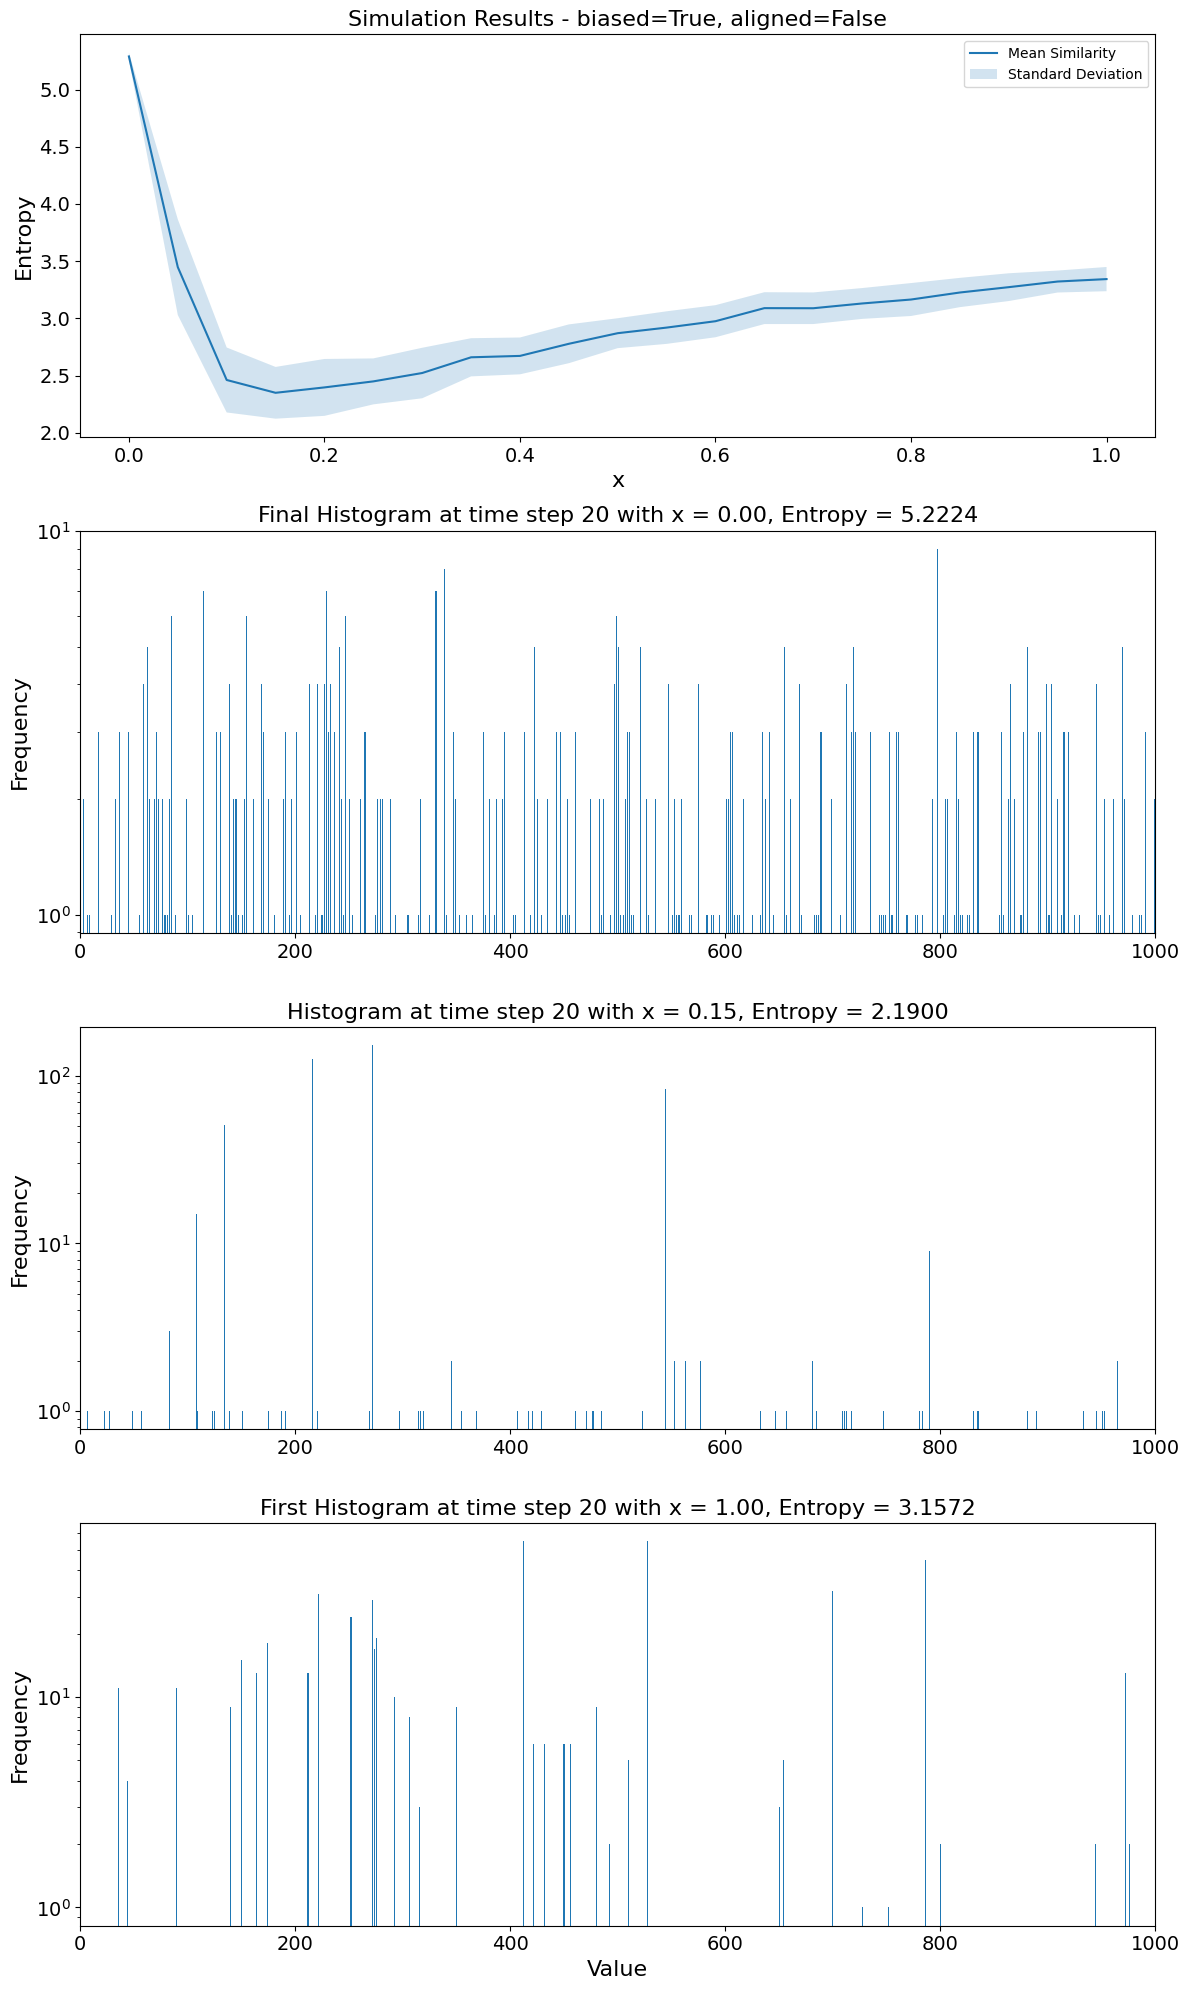

Running 50 simulations with x = 0.0
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share:

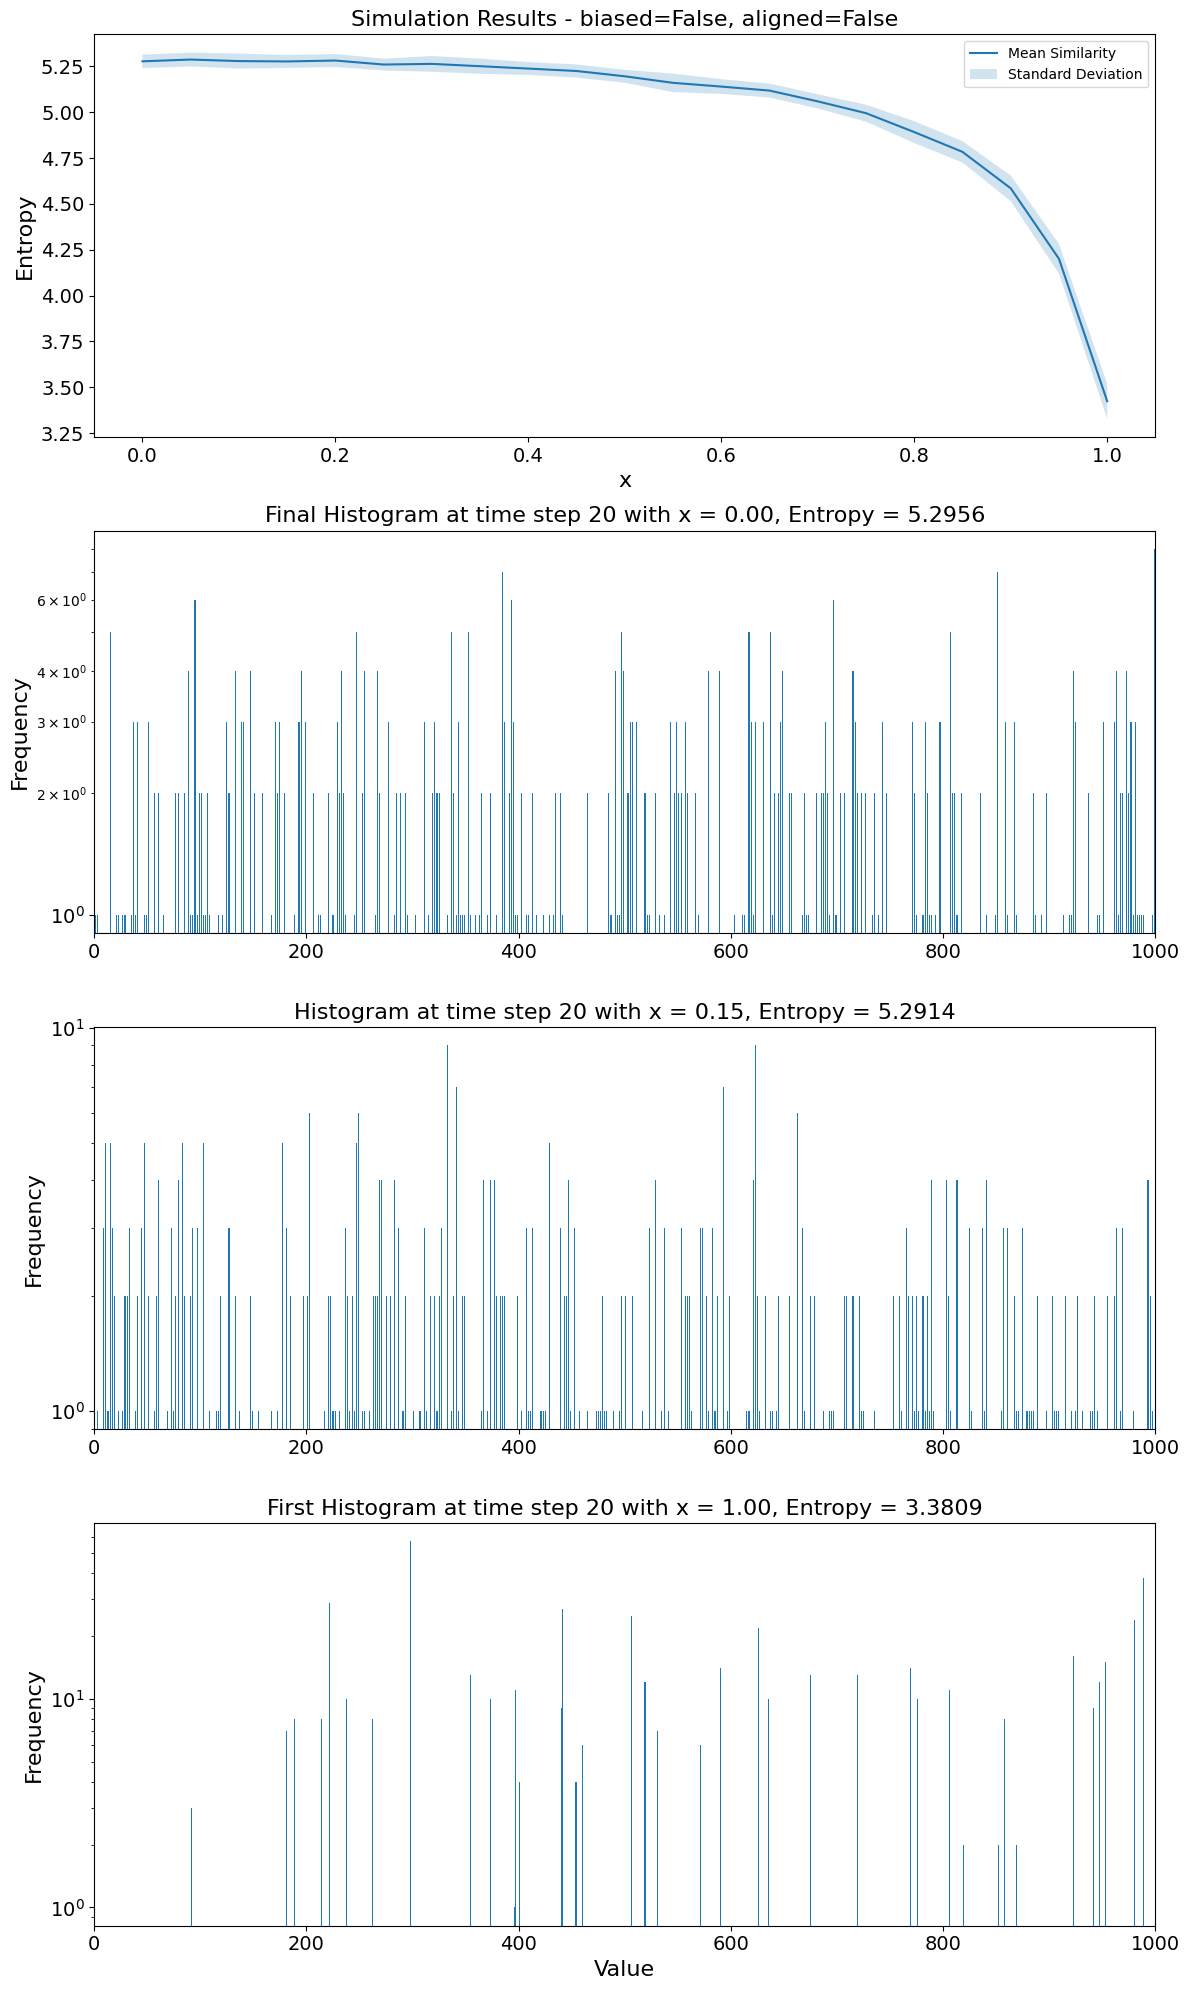

Running 50 simulations with x = 0.0
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share: 500
Human share:

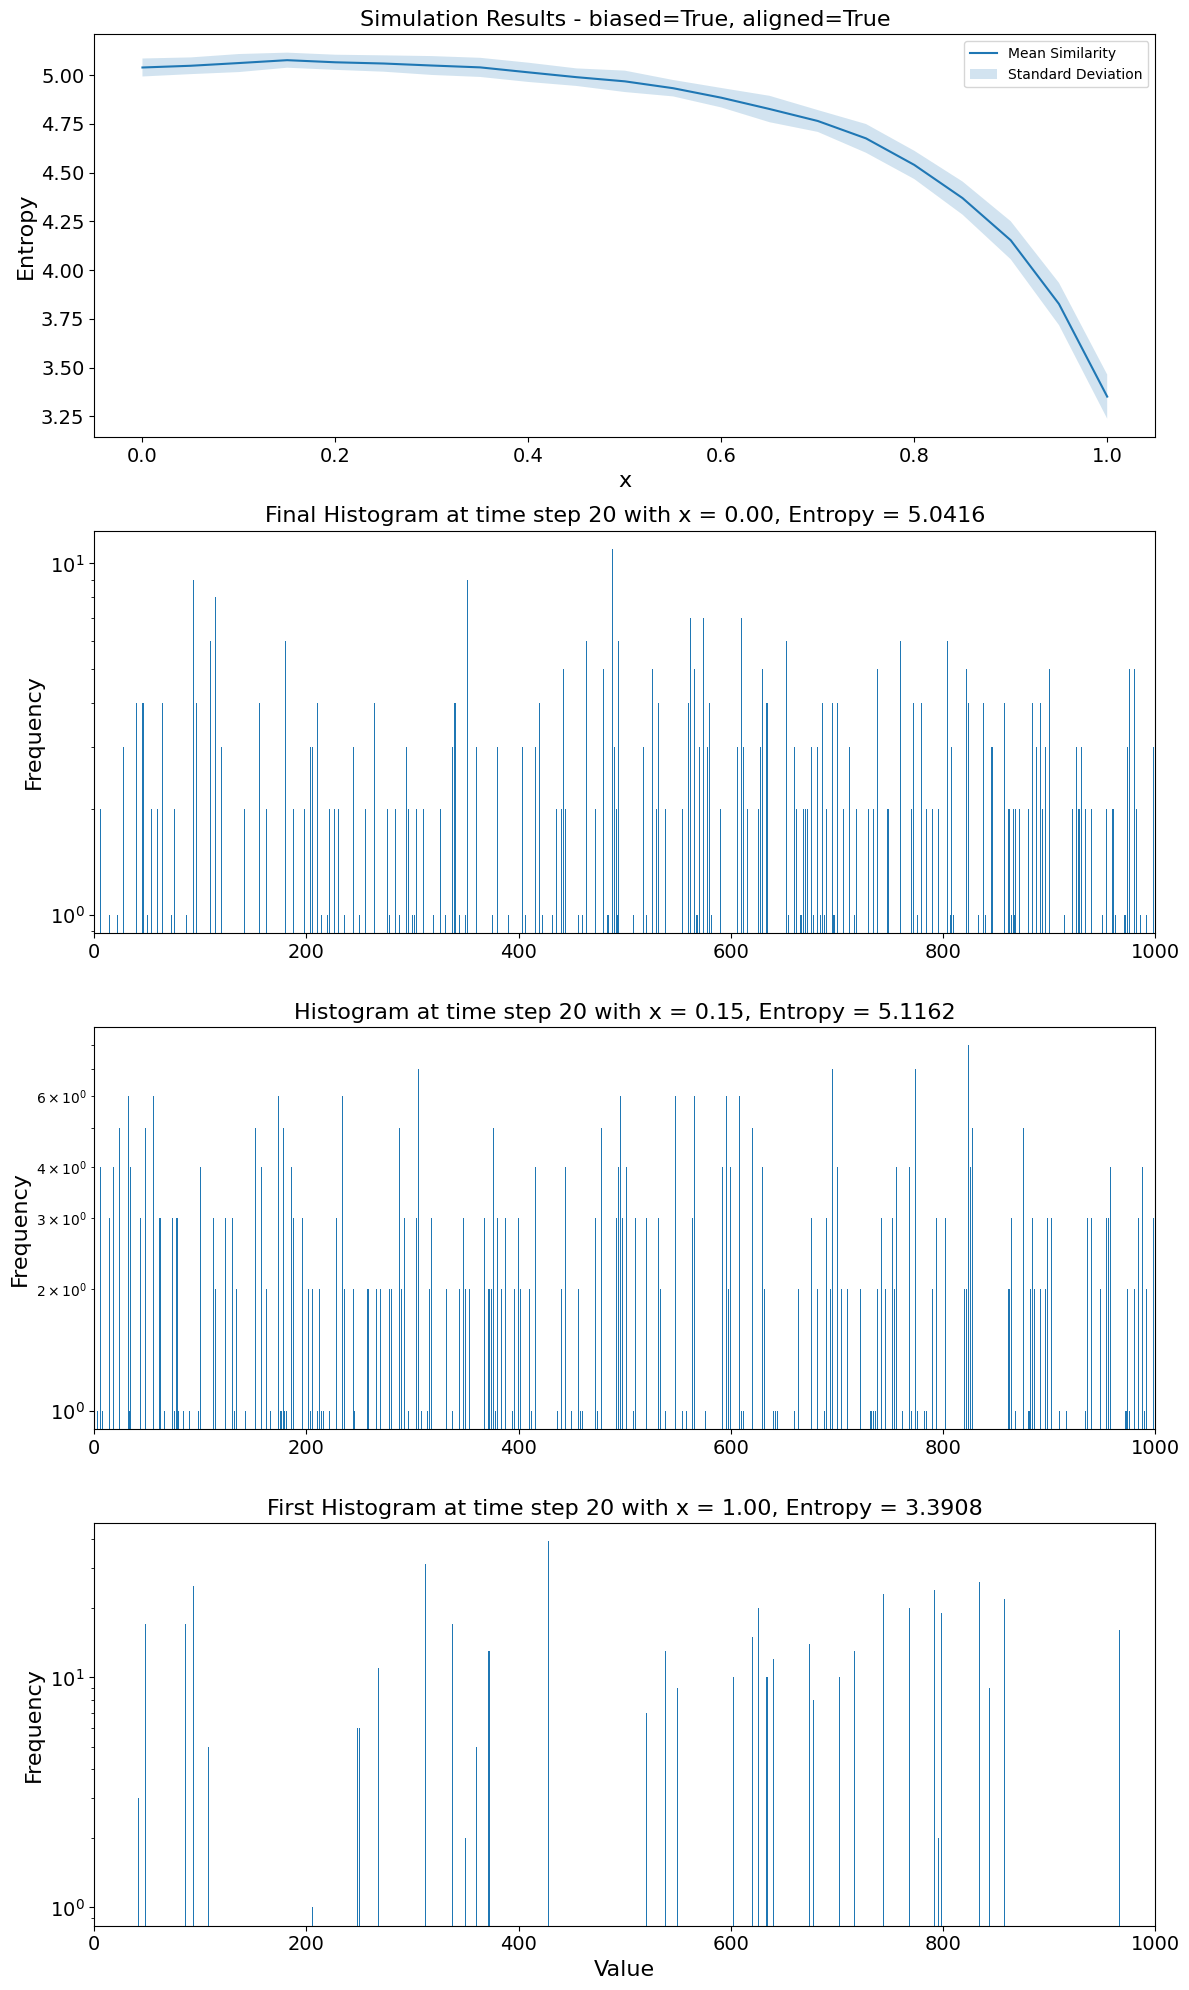

In [121]:
run_and_plot(title="Simulation Results - biased=True, aligned=False", biased=True, aligned=False)
run_and_plot(title="Simulation Results - biased=False, aligned=False", biased=False, aligned=False)
run_and_plot(title="Simulation Results - biased=True, aligned=True", biased=True, aligned=True)
